In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, corr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("PrediksiDiabetes").getOrCreate()

#Memuat Dataset

In [3]:
# Memuat dataset
file_path = "/content/diabetes.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

#Preporocessing Data

In [4]:
# Menampilkan skema dan beberapa baris pertama
data.printSchema()
data.show(10)

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          

In [5]:
# Konversi Spark DataFrame ke Pandas untuk visualisasi
pandas_df = data.toPandas()

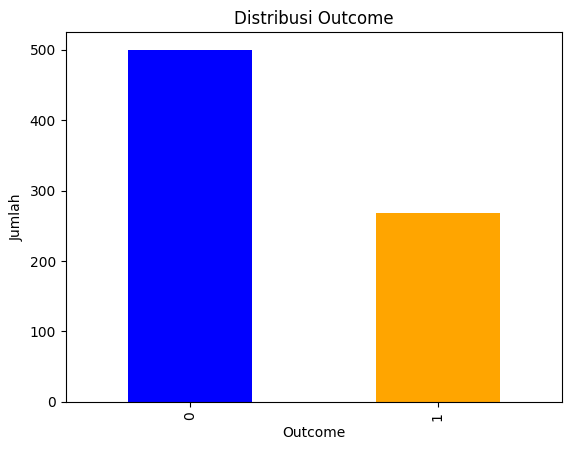

In [6]:
# Diagram batang: Distribusi Outcome
jumlah_outcome = pandas_df["Outcome"].value_counts()
jumlah_outcome.plot(kind="bar", color=["blue", "orange"], title="Distribusi Outcome")
plt.xlabel("Outcome")
plt.ylabel("Jumlah")
plt.show()

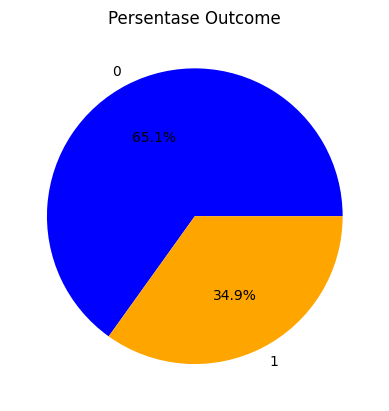

In [7]:
# Diagram pie: Persentase Outcome
jumlah_outcome.plot(kind="pie", autopct='%1.1f%%', colors=["blue", "orange"], title="Persentase Outcome")
plt.ylabel("")
plt.show()

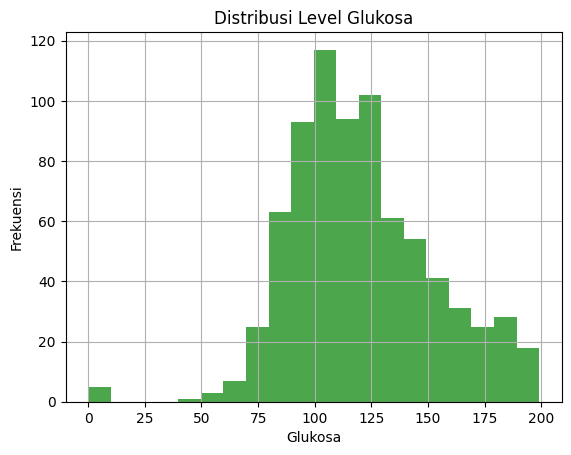

In [8]:
# Histogram: Distribusi Glukosa
pandas_df["Glucose"].hist(bins=20, color="green", alpha=0.7)
plt.title("Distribusi Level Glukosa")
plt.xlabel("Glukosa")
plt.ylabel("Frekuensi")
plt.show()

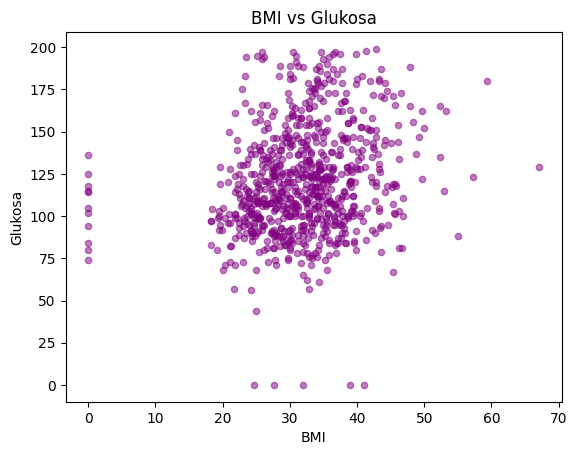

In [9]:
# Diagram sebar: BMI vs. Glukosa
pandas_df.plot.scatter(x="BMI", y="Glucose", alpha=0.5, color="purple", title="BMI vs Glukosa")
plt.xlabel("BMI")
plt.ylabel("Glukosa")
plt.show()

In [10]:
# Memeriksa nilai null
jumlah_null = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])
jumlah_null.show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [11]:
# Statistik ringkasan
data.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [12]:
# Menghitung matriks korelasi
kolom = data.columns[:-1]  # Kecuali kolom target 'Outcome'
korelasi = {}
for nama_kolom in kolom:
    korelasi[nama_kolom] = data.stat.corr(nama_kolom, "Outcome")

In [13]:
# Menampilkan korelasi
print("Korelasi dengan Outcome:")
for nama_kolom, nilai_korelasi in korelasi.items():
    print(f"{nama_kolom}: {nilai_korelasi}")

Korelasi dengan Outcome:
Pregnancies: 0.22189815303398636
Glucose: 0.4665813983068737
BloodPressure: 0.06506835955033274
SkinThickness: 0.07475223191831945
Insulin: 0.13054795488404794
BMI: 0.2926946626444454
DiabetesPedigreeFunction: 0.17384406565296
Age: 0.23835598302719757


In [14]:
# Membuat fitur menjadi vektor
kolom_fitur = [col for col in data.columns if col != 'Outcome']
assembler = VectorAssembler(inputCols=kolom_fitur, outputCol="fitur")
data = assembler.transform(data).select("fitur", "Outcome")

In [15]:
# Membagi data menjadi data latih dan data uji
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

#EDA

In [16]:
# Konversi Spark DataFrame ke Pandas untuk visualisasi
pandas_df = data.toPandas()

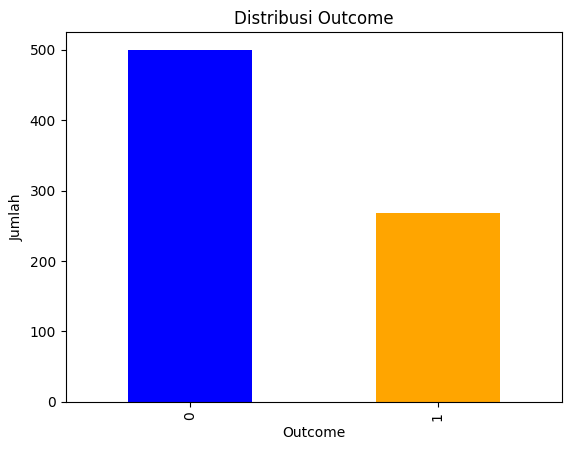

In [17]:
# Diagram batang: Distribusi Outcome
jumlah_outcome = pandas_df["Outcome"].value_counts()
jumlah_outcome.plot(kind="bar", color=["blue", "orange"], title="Distribusi Outcome")
plt.xlabel("Outcome")
plt.ylabel("Jumlah")
plt.show()

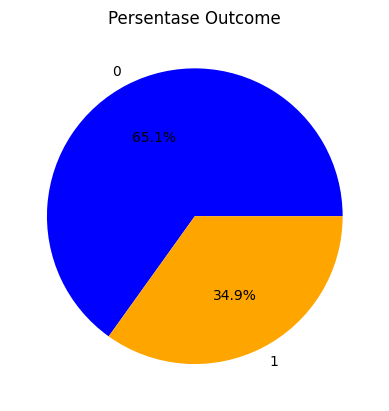

In [18]:
# Diagram pie: Persentase Outcome
jumlah_outcome.plot(kind="pie", autopct='%1.1f%%', colors=["blue", "orange"], title="Persentase Outcome")
plt.ylabel("")
plt.show()

In [19]:
print(kolom_fitur)  # Menampilkan urutan kolom fitur

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [20]:
# Konversi Spark DataFrame ke Pandas untuk visualisasi
# Update pandas_df setelah transformasi data
# Ambil data asli dari kolom "fitur" dengan mengakses elemen pertama
pandas_df = data.select("fitur", "Outcome").toPandas()
pandas_df['Glucose'] = pandas_df['fitur'].apply(lambda x: x[0]) # Assuming 'Glucose' was the first column in your original data

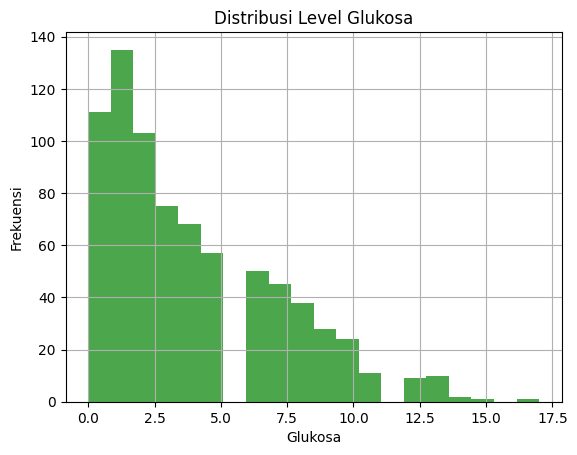

In [21]:
# Histogram: Distribusi Glukosa
pandas_df["Glucose"].hist(bins=20, color="green", alpha=0.7)
plt.title("Distribusi Level Glukosa")
plt.xlabel("Glukosa")
plt.ylabel("Frekuensi")
plt.show()

In [22]:
# Konversi Spark DataFrame ke Pandas untuk visualisasi
# Update pandas_df setelah transformasi data
# Ambil data asli dari kolom "fitur" dengan mengakses elemen pertama
pandas_df = data.select("fitur", "Outcome").toPandas()
pandas_df['Glucose'] = pandas_df['fitur'].apply(lambda x: x[0])  # Assuming 'Glucose' was the first column in your original data
pandas_df['BMI'] = pandas_df['fitur'].apply(lambda x: x[2])  # Assuming 'BMI' was the third column in your original data #This line is added to extract the BMI values from the fitur column. The index [2] is used because 'BMI' is likely the third element in the feature vector (index starts from 0).

<ipython-input-23-a5198981f1ba>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Outcome", y="BMI", data=pandas_df, palette=["blue", "orange"])


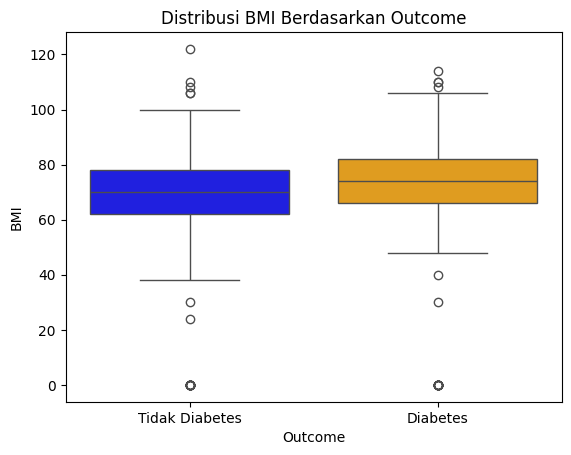

In [23]:
# Boxplot BMI Berdasarkan Outcome
import seaborn as sns

sns.boxplot(x="Outcome", y="BMI", data=pandas_df, palette=["blue", "orange"])
plt.title("Distribusi BMI Berdasarkan Outcome")
plt.xlabel("Outcome")
plt.ylabel("BMI")
plt.xticks([0, 1], labels=["Tidak Diabetes", "Diabetes"])
plt.show()

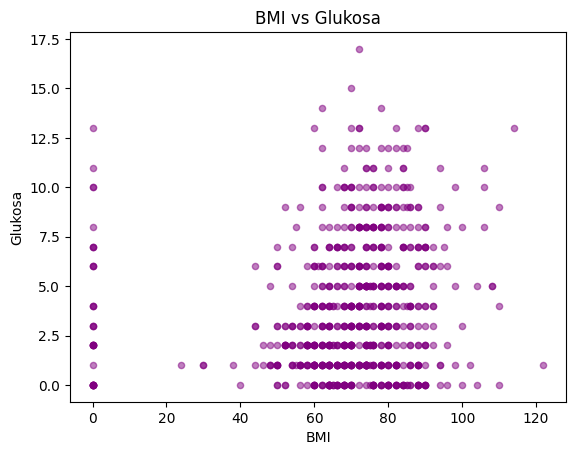

In [24]:
# Diagram sebar: BMI vs. Glukosa
pandas_df.plot.scatter(x="BMI", y="Glucose", alpha=0.5, color="purple", title="BMI vs Glukosa")
plt.xlabel("BMI")
plt.ylabel("Glukosa")
plt.show()

In [25]:
# Cek data untuk pastikan kolom yang dipakai ada isinya
print(pandas_df.head())  # Pastikan ada data di sini
print(pandas_df.describe())  # Cek statistik ringkasan untuk melihat apakah ada nilai yang tidak valid

                                               fitur  Outcome  Glucose   BMI
0   [6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0]        1      6.0  72.0
1    [1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0]        0      1.0  66.0
2    [8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0]        1      8.0  64.0
3   [1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0]        0      1.0  66.0
4  [0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 3...        1      0.0  40.0
          Outcome     Glucose         BMI
count  768.000000  768.000000  768.000000
mean     0.348958    3.845052   69.105469
std      0.476951    3.369578   19.355807
min      0.000000    0.000000    0.000000
25%      0.000000    1.000000   62.000000
50%      0.000000    3.000000   72.000000
75%      1.000000    6.000000   80.000000
max      1.000000   17.000000  122.000000


In [26]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# Evaluator
evaluator_auc = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")

# Function untuk menghitung Akurasi, Presisi, Recall, F1 Score
def calculate_metrics(predictions, label_col="Outcome"):
    tp = predictions.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
    tn = predictions.filter((col(label_col) == 0) & (col("prediction") == 0)).count()
    fp = predictions.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
    fn = predictions.filter((col(label_col) == 1) & (col("prediction") == 0)).count()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

    return accuracy, precision, recall, f1_score

# Model 1: Random Forest
rf = RandomForestClassifier(labelCol="Outcome", featuresCol="fitur", numTrees=100, maxDepth=10)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_auc = evaluator_auc.evaluate(rf_predictions)
rf_accuracy, rf_precision, rf_recall, rf_f1 = calculate_metrics(rf_predictions)

In [27]:
# Model 2: Gradient Boosted Tree
gbt = GBTClassifier(labelCol="Outcome", featuresCol="fitur", maxIter=50, maxDepth=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_auc = evaluator_auc.evaluate(gbt_predictions)
gbt_accuracy, gbt_precision, gbt_recall, gbt_f1 = calculate_metrics(gbt_predictions)



In [28]:
# Model 3: Logistic Regression
lr = LogisticRegression(labelCol="Outcome", featuresCol="fitur", maxIter=50, regParam=0.01)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_auc = evaluator_auc.evaluate(lr_predictions)
lr_accuracy, lr_precision, lr_recall, lr_f1 = calculate_metrics(lr_predictions)

In [29]:
# Model 4: Linear SVC
svc = LinearSVC(labelCol="Outcome", featuresCol="fitur", maxIter=50, regParam=0.1)
svc_model = svc.fit(train_data)
svc_predictions = svc_model.transform(test_data)
svc_auc = evaluator_auc.evaluate(svc_predictions)
svc_accuracy, svc_precision, svc_recall, svc_f1 = calculate_metrics(svc_predictions)

In [30]:
# Hasil Evaluasi
results = [
    ("Random Forest", rf_auc, rf_accuracy, rf_precision, rf_recall, rf_f1),
    ("Gradient Boosted Tree", gbt_auc, gbt_accuracy, gbt_precision, gbt_recall, gbt_f1),
    ("Logistic Regression", lr_auc, lr_accuracy, lr_precision, lr_recall, lr_f1),
    ("Linear SVC", svc_auc, svc_accuracy, svc_precision, svc_recall, svc_f1),
]

In [31]:
# Menampilkan hasil
print("Model Evaluation Results:")
print("{:<25} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Model", "AUC", "Accuracy", "Precision", "Recall", "F1 Score"))
for model, auc, acc, prec, rec, f1 in results:
    print(f"{model:<25} {auc:<10.4f} {acc:<10.4f} {prec:<10.4f} {rec:<10.4f} {f1:<10.4f}")

Model Evaluation Results:
Model                     AUC        Accuracy   Precision  Recall     F1 Score  
Random Forest             0.8452     0.8049     0.6829     0.7179     0.7000    
Gradient Boosted Tree     0.6966     0.7236     0.5806     0.4615     0.5143    
Logistic Regression       0.8825     0.8211     0.7576     0.6410     0.6944    
Linear SVC                0.8849     0.8211     0.7742     0.6154     0.6857    


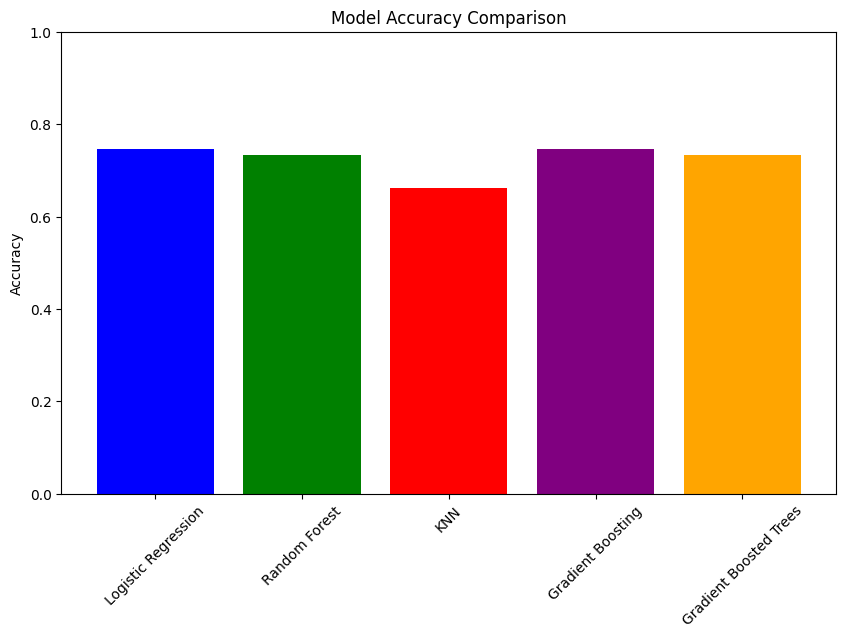

Logistic Regression:
  Accuracy: 0.75
  Precision: 0.73
  Recall: 0.73
  F1-Score: 0.73
--------------------------------------------------
Random Forest:
  Accuracy: 0.73
  Precision: 0.71
  Recall: 0.72
  F1-Score: 0.71
--------------------------------------------------
KNN:
  Accuracy: 0.66
  Precision: 0.64
  Recall: 0.64
  F1-Score: 0.64
--------------------------------------------------
Gradient Boosting:
  Accuracy: 0.75
  Precision: 0.73
  Recall: 0.73
  F1-Score: 0.73
--------------------------------------------------
Gradient Boosted Trees:
  Accuracy: 0.73
  Precision: 0.72
  Recall: 0.73
  F1-Score: 0.72
--------------------------------------------------


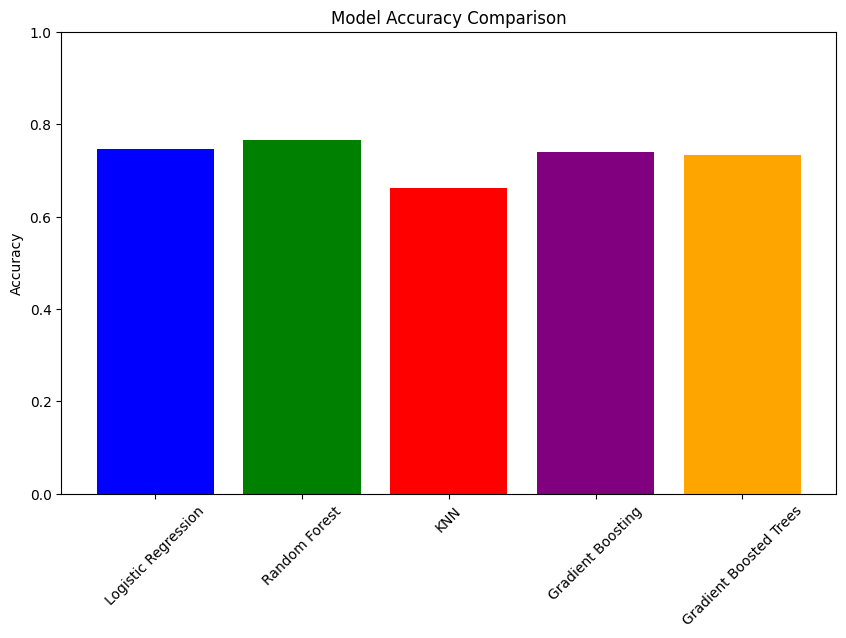

Logistic Regression:
  Accuracy: 0.75
  Precision: 0.73
  Recall: 0.73
  F1-Score: 0.73
--------------------------------------------------
Random Forest:
  Accuracy: 0.77
  Precision: 0.75
  Recall: 0.75
  F1-Score: 0.75
--------------------------------------------------
KNN:
  Accuracy: 0.66
  Precision: 0.64
  Recall: 0.64
  F1-Score: 0.64
--------------------------------------------------
Gradient Boosting:
  Accuracy: 0.74
  Precision: 0.72
  Recall: 0.73
  F1-Score: 0.72
--------------------------------------------------
Gradient Boosted Trees:
  Accuracy: 0.73
  Precision: 0.72
  Recall: 0.73
  F1-Score: 0.72
--------------------------------------------------


In [32]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import monotonically_increasing_id

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = data.toPandas()

# Extract features (X) and target (y)
X = pandas_df['fitur'].values.tolist() # Assuming 'fitur' is your features column
y = pandas_df['Outcome'].values

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import monotonically_increasing_id

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = data.toPandas()

# Extract features (X) and target (y)
X = pandas_df['fitur'].values.tolist() # Assuming 'fitur' is your features column
y = pandas_df['Outcome'].values

# Split dataset menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model Building
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Gradient Boosted Trees": HistGradientBoostingClassifier()
}

# Dictionary untuk menyimpan hasil
accuracies = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Melatih dan menguji model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Menghitung metrik
    accuracies[name] = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Simpan nilai precision, recall, f1-score untuk masing-masing model
    precision_scores[name] = report['macro avg']['precision']
    recall_scores[name] = report['macro avg']['recall']
    f1_scores[name] = report['macro avg']['f1-score']

# 4. Visualisasi Akurasi
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

# Print akurasi, precision, recall, f1-score untuk setiap model
for name in models.keys():
    print(f"{name}:")
    print(f"  Accuracy: {accuracies[name]:.2f}")
    print(f"  Precision: {precision_scores[name]:.2f}")
    print(f"  Recall: {recall_scores[name]:.2f}")
    print(f"  F1-Score: {f1_scores[name]:.2f}")
    print("-" * 50)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Gradient Boosted Trees": HistGradientBoostingClassifier()
}

# Dictionary untuk menyimpan hasil
accuracies = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Melatih dan menguji model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Menghitung metrik
    accuracies[name] = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Simpan nilai precision, recall, f1-score untuk masing-masing model
    precision_scores[name] = report['macro avg']['precision']
    recall_scores[name] = report['macro avg']['recall']
    f1_scores[name] = report['macro avg']['f1-score']

# 4. Visualisasi Akurasi
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

# Print akurasi, precision, recall, f1-score untuk setiap model
for name in models.keys():
    print(f"{name}:")
    print(f"  Accuracy: {accuracies[name]:.2f}")
    print(f"  Precision: {precision_scores[name]:.2f}")
    print(f"  Recall: {recall_scores[name]:.2f}")
    print(f"  F1-Score: {f1_scores[name]:.2f}")
    print("-" * 50)

In [33]:
from sklearn.ensemble import RandomForestClassifier as sk_RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Keep this for PySpark's RandomForestClassifier:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, LinearSVC

# Membuat evaluator untuk AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")

# Membuat model RandomForest
rf = RandomForestClassifier(labelCol="Outcome", featuresCol="fitur", numTrees=100, maxDepth=10)

# Menyusun param grid untuk RandomForest
rf_param_grid = (ParamGridBuilder()
                 .addGrid(RandomForestClassifier.maxDepth, [5, 10, 15])  # Variasi kedalaman pohon
                 .addGrid(RandomForestClassifier.numTrees, [50, 100, 150])  # Variasi jumlah pohon
                 .build())

# Cross-validation untuk RandomForest
crossval_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=evaluator_auc,
    numFolds=5  # Menggunakan 5-fold cross-validation
)

# Melakukan pelatihan dan memilih model terbaik untuk RandomForest
rf_model_cv = crossval_rf.fit(train_data)

# Mendapatkan model terbaik dan AUC terbaik
rf_best_model = rf_model_cv.bestModel
rf_best_auc = rf_model_cv.avgMetrics[0]

# Tampilkan hasil AUC terbaik
print(f"Random Forest - Best AUC: {rf_best_auc:.4f}")

# Menggunakan model terbaik untuk evaluasi pada data uji
rf_best_model_predictions = rf_best_model.transform(test_data)

# Evaluasi model terbaik RandomForest
rf_best_model_auc = evaluator_auc.evaluate(rf_best_model_predictions)
rf_best_model_accuracy, rf_best_model_precision, rf_best_model_recall, rf_best_model_f1 = calculate_metrics(rf_best_model_predictions)

# Menampilkan hasil evaluasi untuk RandomForest
print("\nEvaluasi Model Terbaik - Random Forest:")
print(f"AUC: {rf_best_model_auc:.4f}")
print(f"Accuracy: {rf_best_model_accuracy:.4f}")
print(f"Precision: {rf_best_model_precision:.4f}")
print(f"Recall: {rf_best_model_recall:.4f}")
print(f"F1-Score: {rf_best_model_f1:.4f}")

Random Forest - Best AUC: 0.8005

Evaluasi Model Terbaik - Random Forest:
AUC: 0.8452
Accuracy: 0.8049
Precision: 0.6829
Recall: 0.7179
F1-Score: 0.7000


In [34]:
# Membuat model Gradient Boosted Tree
gbt = GBTClassifier(labelCol="Outcome", featuresCol="fitur", maxIter=50, maxDepth=10)

# Menyusun param grid untuk Gradient Boosted Tree
gbt_param_grid = (ParamGridBuilder()
                  .addGrid(GBTClassifier.maxDepth, [5, 10, 15])  # Variasi kedalaman pohon
                  .addGrid(GBTClassifier.maxIter, [50, 100])  # Variasi jumlah iterasi
                  .build())

# Cross-validation untuk Gradient Boosted Tree
crossval_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=gbt_param_grid,
    evaluator=evaluator_auc,
    numFolds=5  # Menggunakan 5-fold cross-validation
)

# Melakukan pelatihan dan memilih model terbaik untuk Gradient Boosted Tree
gbt_model_cv = crossval_gbt.fit(train_data)

# Mendapatkan model terbaik dan AUC terbaik
gbt_best_model = gbt_model_cv.bestModel
gbt_best_auc = gbt_model_cv.avgMetrics[0]

# Tampilkan hasil AUC terbaik
print(f"Gradient Boosted Tree - Best AUC: {gbt_best_auc:.4f}")

# Menggunakan model terbaik untuk evaluasi pada data uji
gbt_best_model_predictions = gbt_best_model.transform(test_data)

# Evaluasi model terbaik Gradient Boosted Tree
gbt_best_model_auc = evaluator_auc.evaluate(gbt_best_model_predictions)
gbt_best_model_accuracy, gbt_best_model_precision, gbt_best_model_recall, gbt_best_model_f1 = calculate_metrics(gbt_best_model_predictions)

# Menampilkan hasil evaluasi untuk Gradient Boosted Tree
print("\nEvaluasi Model Terbaik - Gradient Boosted Tree:")
print(f"AUC: {gbt_best_model_auc:.4f}")
print(f"Accuracy: {gbt_best_model_accuracy:.4f}")
print(f"Precision: {gbt_best_model_precision:.4f}")
print(f"Recall: {gbt_best_model_recall:.4f}")
print(f"F1-Score: {gbt_best_model_f1:.4f}")

Gradient Boosted Tree - Best AUC: 0.7187

Evaluasi Model Terbaik - Gradient Boosted Tree:
AUC: 0.6966
Accuracy: 0.7236
Precision: 0.5806
Recall: 0.4615
F1-Score: 0.5143


In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName("ModelComparison").getOrCreate()

# Memuat dataset
data = spark.read.csv("diabetes.csv", header=True, inferSchema=True)

# Menangani nilai kosong (jika ada)
data = data.na.fill(0)

# Membuat fitur input
feature_columns = data.columns[:-1]  # Semua kolom kecuali "Outcome"
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Membagi data menjadi train dan test
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Inisialisasi model
rf = RandomForestClassifier(labelCol="Outcome", featuresCol="features", seed=42)
gbt = GBTClassifier(labelCol="Outcome", featuresCol="features", seed=42, maxIter=50)

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")

# Random Forest
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_predictions)

# Gradient Boosted Tree
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_auc = evaluator.evaluate(gbt_predictions)

# Hasil
print(f"Random Forest AUC: {rf_auc}")
print(f"Gradient Boosted Tree AUC: {gbt_auc}")

# Memilih model terbaik
if rf_auc > gbt_auc:
    print("Random Forest adalah model terbaik untuk dataset ini.")
else:
    print("Gradient Boosted Tree adalah model terbaik untuk dataset ini.")


Random Forest AUC: 0.8377906976744187
Gradient Boosted Tree AUC: 0.7909883720930234
Random Forest adalah model terbaik untuk dataset ini.


In [47]:
from pyspark.ml.tuning import CrossValidatorModel

# Simpan model Random Forest terbaik
rf_best_model.save("best_model_random_forest")

Dari analisis kami, Random Forest benar-benar merupakan pilihan yang tepat untuk dataset ini karena kemampuannya dalam memanfaatkan korelasi kuat antar fitur, seperti hubungan antara **Glucose** dan **Outcome**, yang sangat relevan dalam prediksi diabetes. Selain itu, model ini dapat menangani hubungan non-linear antar fitur, seperti **BMI** dan **Age**, tanpa perlu usaha tambahan untuk transformasi data. Random Forest mampu mengatasi outlier dan noise yang sering muncul dalam dataset medis, memberikan performa yang stabil dan andal. Dengan fleksibilitasnya dalam menangani skala data yang berbeda, fitur seperti **Insulin** dan **BloodPressure** dapat dimasukkan tanpa khawatir akan memengaruhi hasil secara negatif. Kombinasi dari semua karakteristik ini menjadikan Random Forest adalah pilihan yang solid untuk dataset ini, terutama dengan risiko overfitting yang minim berkat pendekatan ensambelnya.

Namun, di sisi lain, Random Forest memiliki keterbatasan dalam hal interpretasi. Dalam konteks medis, di mana penjelasan model bisa menjadi faktor krusial, hal ini mungkin menjadi tantangan. Selain itu, jika dataset mengandung banyak fitur yang kurang relevan, model ini tetap menggunakan semua fitur, yang bisa menurunkan efisiensi. Kami juga berpikir bahwa pada pola data yang sangat kompleks, Gradient Boosted Tree mungkin memiliki keunggulan tersendiri. Walaupun begitu, berdasarkan karakteristik dataset ini, kami merasa Random Forest tetap menjadi pilihan terbaik yang seimbang antara performa dan fleksibilitas.